# Medición de flujo vehicular mediante una CNN

## Bibliotecas generales

Se importan bibliotecas generales que serán utilizadas durante todo el proyecto.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Lectura de datos

Para la lectura de datos, se obtienen las rutas de acceso a cada una de las imágenes siguiendo la siguiente estrucutra:

<img src="media/folder_dataset.png">

Posteriormente se crea un dataframe con la ruta y su respectiva etiqueta.

In [2]:
import os

classLabel = ""
imagePath = []
labels = []
categories = {"non-vehicles": 0, "vehicles": 1}

# Escanea los directores dentro de la carpeta dataset
for dirname, _, filenames in os.walk("dataset/"):
    print(dirname)
    if (dirname.split("/")[-1] != "dataset"):
        classLabel = dirname.split("/")[-1]

    for filename in filenames:
        imagePath.append(dirname + "/" + filename)
        labels.append(categories[classLabel])

dataset/
dataset/non-vehicles
dataset/vehicles


## Dataframe

Se obtiene un dataframe con todas las rutas de acceso a las imágenes y con su respectiva etiqueta.

In [3]:
dataset = pd.DataFrame({"path": imagePath, "label": labels})
dataset

,path,label
0,dataset/non-vehicles/extra1.png,0
1,dataset/non-vehicles/extra10.png,0
2,dataset/non-vehicles/extra100.png,0
3,dataset/non-vehicles/extra1000.png,0
4,dataset/non-vehicles/extra1001.png,0
...,...,...
17755,dataset/vehicles/right (95).png,1
17756,dataset/vehicles/right (96).png,1
17757,dataset/vehicles/right (97).png,1
17758,dataset/vehicles/right (98).png,1


### Remuestreo de datos

Se ordena aleatoriamente las imágenes para evitar sesgo durante la etapa de entrenamiento.

In [4]:
shuffle_dataset = dataset.sample(frac=1).reset_index()
shuffle_dataset

,index,path,label
0,14035,dataset/vehicles/5562.png,1
1,12388,dataset/vehicles/408.png,1
2,3745,dataset/non-vehicles/extra4899.png,0
3,10708,dataset/vehicles/2568.png,1
4,11047,dataset/vehicles/2873.png,1
...,...,...,...
17755,16758,dataset/vehicles/middle (172).png,1
17756,3085,dataset/non-vehicles/extra4172.png,0
17757,12905,dataset/vehicles/4545.png,1
17758,11760,dataset/vehicles/3514.png,1


## Preprocesado de datos

Para el procesado se realizarán las siguientes transformaciones:

* Se redimensionarán las imágenes a un tamaño fijo de (32, 32, 3).
* Los valores de las imágenes se normalizarán en una escala de 0 a 1.

In [5]:
from skimage.transform import resize

images = []
labels = shuffle_dataset["label"]

for path in shuffle_dataset["path"]:
    image = plt.imread(path)
    resizedImage = resize(image, (32,32,3))
    images.append(resizedImage)

images = np.array(images)
images = images/255

## Limpeado de memoria

Se realiza un limpiado de memoria para liberar memoria cache.

In [6]:
import gc

del dataset
gc.collect()

16

## Imágenes procesadas

Se imprime un conjunto de 9 imágenes ya procesadas con su etiqueta.

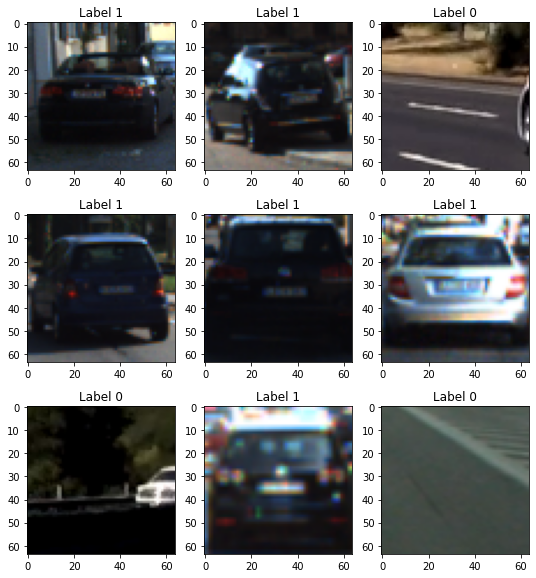

In [7]:
plt.figure(figsize=(9,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    #print(shuffle_dataset["label"][i])
    im = plt.imread(shuffle_dataset["path"][i])
    plt.title("Label "+str(shuffle_dataset["label"][i]))
    plt.imshow(im)
plt.show()

### Preparación de datos de entrada

Para la fase de entrenamiento, el set de datos se partió en tres partes como se muestra en la siguiente figura.

<img src="media/dataset_proyect.png" width=400>

In [8]:
from sklearn.model_selection import train_test_split

# Aquí se parte el set de datos, siendo el train-set el 80% y el test-set 20%.
X_train,X_test,y_train,y_test = train_test_split(images,labels.values,test_size=0.2)

In [10]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_train_one_hot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [11]:
X_train.shape, y_train.shape

((14208, 32, 32, 3), (14208,))

## CNN

La siguiente parte consiste en la creación de la Red Neural Convolucional, para este proyecto se eligirá la siguiente arquitectura:

<img src="media/cnn.png">

### Bibliotecas

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout

### Construcción del Modelo

El modelo propuesto anteriormente se construirá en el siguiente bloque.

In [13]:
model = Sequential()

# Bloque 1
model.add(Conv2D(32,(5,5),activation="relu",input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Bloque 2
model.add(Conv2D(32,(5,5),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa flatten
model.add(Flatten())

# Block 3
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

### Comilado del Modelo

In [14]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Entrenamiento del Modelo

In [15]:
hist = model.fit(X_train,y_train_one_hot,
                 epochs=50,
                 validation_split=0.2,
                 use_multiprocessing=True)

Epoch 1/50
356/356 [==============================] - 8s 22ms/step - loss: 0.5812 - accuracy: 0.6798 - val_loss: 0.4255 - val_accuracy: 0.8086
Epoch 2/50
356/356 [==============================] - 8s 21ms/step - loss: 0.3979 - accuracy: 0.8262 - val_loss: 0.3527 - val_accuracy: 0.8568
Epoch 3/50
356/356 [==============================] - 8s 21ms/step - loss: 0.3465 - accuracy: 0.8521 - val_loss: 0.3061 - val_accuracy: 0.8733
Epoch 4/50
356/356 [==============================] - 8s 21ms/step - loss: 0.3155 - accuracy: 0.8674 - val_loss: 0.2758 - val_accuracy: 0.8948
Epoch 5/50
356/356 [==============================] - 8s 21ms/step - loss: 0.2847 - accuracy: 0.8797 - val_loss: 0.2524 - val_accuracy: 0.8937
Epoch 6/50
356/356 [==============================] - 8s 21ms/step - loss: 0.2646 - accuracy: 0.8862 - val_loss: 0.2330 - val_accuracy: 0.9046
Epoch 7/50
356/356 [==============================] - 8s 21ms/step - loss: 0.2328 - accuracy: 0.9042 - val_loss: 0.2695 - val_accuracy: 0.8860

### Evaluación del modelo

#### Accuracy

Para evaluar el desempeño del modelo se usa la métrica accuracy.

In [16]:
model.evaluate(X_test,y_test_one_hot)[1]

111/111 [==============================] - 1s 5ms/step - loss: 0.0715 - accuracy: 0.9794


0.9794481992721558

#### Curvas de Aprendizaje

En esta sección se muestran las curvas de aprendizaje del modelo entrenado.

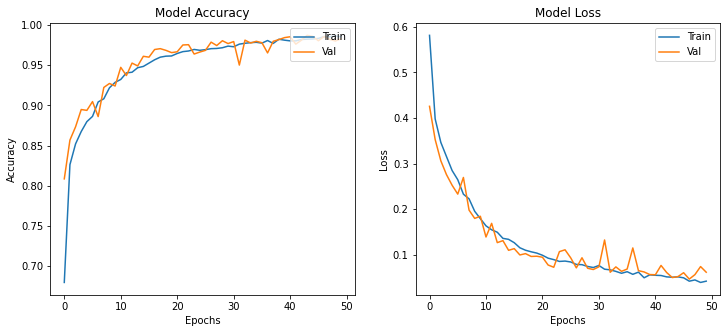

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train","Val"],loc="upper right")

plt.subplot(1,2,2)
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

### Exportar modelo

In [18]:
model.save("modelo_car.h5")